## Driving a smart cab using Q-learning

### Vivek Yadav, PhD 

#### Abstract

This document presents the work I did on applying Q-learning algorithm for Udacity's self-driving cab project for [Udacity's machine learning nano-degree](https://www.udacity.com/course/machine-learning-engineer-nanodegree--nd009). 
In this project, I applied Q-learning to develop algorithm to autonomously drive a smartcab around in city. The smartcab navigates from one intersection to another, and at each intersection the cab recieves input regarding the traffic light,  next way point, and information about oncoming traffic. I modified the 'environment.py' and 'agent.py' functions to developed the controller in stages. Python notebook with code for testing algorithm is presented here. 

In the first stage, I compared the performance of Q-learning algorithm by using the traffic light,  next way point, and information about oncoming traffic as state inputs vs. another case where the smartcab made decisions based solely on traffic light and  next way point.  Purpose of doing so was to test if Q-learning algorithm is implemented correctly (sanity check) as follows, 
1. It is expected that a smartcab operating without information of oncoming traffic and one with oncoming traffic information should perform similar when there is almost no oncoming traffic. 
2. As the traffic is increased, it is expected that the Q-learning algorithm that does not include information of traffic will make erroneous decisions. I verified this by comparing performance of Q-learning algroithms with 2 and 5 states for 3, 20 and 40 other agents in the environment. 

Once I verified that the Q-learning algorithm was implemented correctly, I chose the agent that takes 5 inputs, and trained it for different number of agents in the environments. Q-learning algorithm was characterized by 2 parameters, \\( \alpha \\) and \\( \gamma \\). \\( \gamma \\) characterizes how much we trust the result from unconverged \\( Q \\), and \\( alpha \\) characterizes how much we trust the current trial to be similar to the states we expect to see in operating conditions. After performing simulations, I found \\( \gamma = 0.5 \\) and \\( \alpha =0.3 \\) gave stable performance. In all cases, the Q-learner reached destination alway. Only when the environment had 40 agents, the smartcab reached the destination 2 steps after the deadline.


PS: While implementing Q-learning algorithm, I indexed elements of Q using a string composed of state-action pairs. I initialized and updated Q for a particular state-action pair only if the smartcab vistied that  state-action pair. This resulted in faster learning Q. 


#### Implementing a Basic Driving Agent: Random driving. 

The first task was to implement a basic driving agent. For this part, I implemented a random sequence generator to choose from an action from a given set of actions. The random action selection was implemented by generating a random integer between 0 and 3, and using this as index to identify the next set of action. 

In [ ]:
# TODO: Select action according to your policy
action_random = [None, 'forward', 'left', 'right']
rand_action = action_random[random.randint(0,3)]
action = rand_action

#### Question: 
Observe what you see with the agent's behavior as it takes random actions. Does the smartcab eventually make it to the destination? Are there any other interesting observations to note?

#### Response: 

To test the behavior of the random agent, I ran simulation with no deadline enforced. A stopping criteria was implemented where if the car did not reach the desired target in 100 more than allowed steps, the simulation ended. In about 75% of the trials, the car did not reach the target. The red dots indicate the trials where the simulation was terminated because the number of steps were 100 more than the allowed time. Simulation was terminated due to long run time in 25% of the cases. The blue line indicates deadline, therefore the trip ended early if the black dot was above the blue line.

<img src="random_state.png">

The random agent completely disregards the location of the target and the neighboring cars while choosing its actions. However, as the car is exploring the entire area, it is expected that it will visit all the states. 

Note: To get the plots above, I modified the environment.py function to return steps taken and desired time (deadline). The code to perform random actions is presented in agent_random.py.

#### Question: 
What states have you identified that are appropriate for modeling the smartcab and environment? Why do you believe each of these states to be appropriate for this problem?

#### Response: 

States of the system were chosen as follows, 
1. Light: Light indicates if a crossing is green or red, as we want the car to cross the intersection when the signal is green, it was included as a state in the model. 
2. Next waypoint: It is crucial to know which direction to turn to, to go towards target. Therefore, I included this as a state. 
3. Oncoming, Left, Right: I also included the directions of the oncoming cars. 

I did not include deadline in the model. Mainly because the planner returns the shortest path, and as traffic is low (only 3 cars), the chances of the smartcab getting stuck due to traffic and having to adopt a different strategy to meet deadline is highly unlikely. Further, adding deadline would require that all the states be visited, and as deadline is a countinuous variable, it could result in significantly large number of states that have to be mapped to actions. This could have been avoided by splitting deadline into coaser qualitative intervals (such as more, normal, short) to get lower number of state combinations. However, I did not include deadline in the model because for this application, the deadline is expected to have little impact.


#### Question: 
How many states in total exist for the smartcab in this environment? Does this number seem reasonable given that the goal of Q-Learning is to learn and make informed decisions about each state? Why or why not?

#### Response: 

The total number of possible of states is 2 (T/F for light) X 3 (F/L/R next waypoint) X 4 (N/F/L/R for oncoming) X 4 (N/F/L/R for Left) X 4 (N/F/L/R for Right) = 384. The total number of controls possible is 4 (N/F/L/R), therefore, total number of state-control combinations possible is 1536. As we are running simulations for 1000 trials, and assuming the car moves on average 20 times per trial, it is highly likely that the car will visit most of the 1536 possible states. Further, most states are highly unlikely because there are only 3 other cars in the environment. So the states corresping to the situation that all cars are at the same intersection is highly unlikely. Therefore, it would be ok for training purposes to ignore the oncoming traffic variables and train only using 6 state variables, 2 (T/F for light) X 3 (F/L/R next waypoint) and 4 controls (N/F/L/R), i.e. 24 state-control combinations. To test this, I will compare the performance of controllers based on 2 states (light and waypoint) and on 5 (light, waypoint, and 3 oncoming) states. 

### Implement a Q-Learning Driving Agent

The Q-Learning algorithm was implemented:
1. Set the \\( \gamma \\) and \\( \alpha \\) parameter, and environment rewards in matrix R.
2. Select a random initial state. If the state-action pair has not been visited previously, set \\( Q(state,action)=0 .\\)
4. Do While the goal state hasn't been reached.
    - Select one among all possible actions for the current state. If a state-action pair has not been visited previously, set \\( Q(state,action)=0 .\\) for them.
    - Using this possible action, consider going to the next state.
    - Get maximum Q value for this next state based on all possible actions.
    - Compute: \\( Q(state, action) = (1 -  \alpha) Q(state, action)  + \alpha \left[ R(state, action) + \gamma ~ max[Q(next~state, all~actions)] \right] \\)
    - Set the next state as the current state.
    
The model above has 2 parameters, \\( \alpha \\) and \\( \gamma \\), \\( \gamma \\) characterizes how much we trust the result from unconverged \\( Q \\), and \\( alpha \\) characterizes how much we trust the current trial to be similar to the states we expect to see in operating conditions. For initial testing,  \\( \alpha = 1 \\) and \\( \gamma = 0.1\\) were selected. After initial experimentation, crossvalidation was performed to obtain the best \\( \alpha \\) and \\( \gamma \\) values. 

In [ ]:
# TODO: Select action according to your policy
Q_actions = []
for action_i in valid_actions:
    str_state_action = [str(s) for s in self.state ]
    str_state_action.append(str(action_i))
    str_state_action  = ",".join(str_state_action)
    if len(self.Q_prev)==0:
        self.Q_prev[str_state_action] = 0
        Q_actions.append(0)
    else:
        if str_state_action in self.Q_prev.keys():
            Q_actions.append(self.Q_prev[str_state_action])
        else:
            self.Q_prev[str_state_action] = 0
            Q_actions.append(0)

Q_max = max(Q_actions)
action_max_inds = [valid_actions[i] for i in range(len(valid_actions)) if Q_max == Q_actions[i]]
action = random.choice(action_max_inds)

str_state_action_now = [str(s) for s in self.state ]
str_state_action_now.append(str(action))
str_state_action_now  = ",".join(str_state_action_now)

# Execute action and get reward
reward = self.env.act(self, action)
self.Q_prev[str_state_action_now] += self.alpha*(reward + self.gamma*Q_max)

### Question: 
What changes do you notice in the agent's behavior when compared to the basic driving agent when random actions were always taken? Why is this behavior occurring?

### Response:

Overall, the smart cab was able to reach the target destination within deadline most of the times. The smartcab learned how to drive around in the environment. More surprisingly, the car learned this in less than 2-3 trials, and in most cases within 1 trial. I compared performance of the smartcab using Q-learning while operating in environment with 3, 20 or 40 other cars/agents. I also tested the effect of using 2 (traffic,  and waypoint) vs 5 ( traffic, oncoming and waypoint) state variables for learning. 

#### Random vs Q-learning with 3, 20 and 40 other agents with traffic, oncoming and waypoint state variables. 

Figure, below shows the difference between deadline and number of steps, a positive number indicates how early the smartcab arrived. For values below 0 (indicated by blue line), the smartcab took longer than deadline, and the cases where the smartcab did not find target are indicated by red dots. 

<img src="random_state_W2040_5states.png">

Figure above compares random agent to the outcome from Q-learning for the cases when there are 3 and 20 agents in the environment. As can be seen, for most of the cases, the Q-learning algorithm took the smartcab to the target location before the deadline, inspite of the fact that deadline was not included in the state space model. Table below presents the state-action pairs sorted by the value of Q-function. In all 3 scenarios, the smartcab moves ahead if the signal is green, waypoint is ahead and there is no oncoming traffic. Further, in all cases, the states corresponding to no oncoming traffic dominate. Probabaly because states where no traffic is present is more likely.



<div>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Q-3 (light,oncoming,left,right,way-point,action)</th>
      <th>Q-20 (light,oncoming,left,right,way-point,action)</th>
      <th>Q-40 (light,oncoming,left,right,way-point,action)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>(green,None,None,None,forward,forward)</td>
      <td>(green,None,None,None,forward,forward)</td>
      <td>(green,None,None,None,forward,forward)</td>
    </tr>
    <tr>
      <th>1</th>
      <td>(green,None,None,None,left,left)</td>
      <td>(green,None,None,None,right,right)</td>
      <td>(green,None,None,None,right,right)</td>
    </tr>
    <tr>
      <th>2</th>
      <td>(red,None,None,None,right,right)</td>
      <td>(green,None,None,None,left,left)</td>
      <td>(green,None,None,None,left,left)</td>
    </tr>
    <tr>
      <th>3</th>
      <td>(green,None,None,None,right,right)</td>
      <td>(red,None,None,None,right,right)</td>
      <td>(red,None,None,None,right,right)</td>
    </tr>
    <tr>
      <th>4</th>
      <td>(green,left,None,None,forward,forward)</td>
      <td>(green,None,None,right,forward,forward)</td>
      <td>(green,None,None,right,forward,forward)</td>
    </tr>
    <tr>
      <th>5</th>
      <td>(green,None,None,forward,forward,forward)</td>
      <td>(green,left,None,None,forward,forward)</td>
      <td>(green,None,left,None,forward,forward)</td>
    </tr>
    <tr>
      <th>6</th>
      <td>(green,None,None,left,left,left)</td>
      <td>(green,None,None,left,forward,forward)</td>
      <td>(green,left,None,None,left,left)</td>
    </tr>
    <tr>
      <th>7</th>
      <td>(green,None,None,right,forward,forward)</td>
      <td>(green,None,None,forward,forward,forward)</td>
      <td>(green,None,None,forward,forward,forward)</td>
    </tr>
    <tr>
      <th>8</th>
      <td>(green,None,left,None,right,right)</td>
      <td>(green,None,left,None,forward,forward)</td>
      <td>(green,None,None,left,forward,forward)</td>
    </tr>
    <tr>
      <th>9</th>
      <td>(green,None,None,left,forward,forward)</td>
      <td>(green,None,forward,None,right,right)</td>
      <td>(green,right,None,None,forward,forward)</td>
    </tr>
  </tbody>
</table>
</div>


#### Q-learning for 2 ( traffic,  and waypoint state variables) and 5 states ( traffic, oncoming and waypoint state variables ) with 3, 20 and 40 other agents. 

Figures below present performance of smartcab (deadline - steps) for the cases when 5 and 2 states were used. Figure on top shows that when all 5 states were available, the car was able to learn how to deal with multiple scenarios that may arise due to traffic. However, when the state variables relating to oncoming traffic were not included, the smartcab performed well when there were only 3 agents. But with more agents in the environment, the smartcab's performance degraded. This degradation happened later in training primarily because the smartcab by then had learned a bad control strategy. 

<img src="Q_5states_32040.png">
<img src="Q_2states_32040.png">



### Improve the Q-Learning Driving Agent

The smartcab's \\( Q(state, action) = (1 -  \alpha)Q(state, action)  + \alpha \left[ R(state, action) + \gamma ~ max[Q(next~state, all~actions)] \right] \\). The learner model  has 2 parameters, \\( \alpha \\) and \\( \gamma \\), \\( \gamma \\) characterizes how much we trust the result from unconverged \\( Q \\), and \\( alpha \\) characterizes how much we trust the current trial to be similar to the states we expect to see in operating conditions. For initial testing,  \\( \alpha = 1 \\) and \\( \gamma = 0.1\\) were selected. I next varied \\( \alpha \\) and \\( \gamma \\) will between 0 and 1, in increments of 0.1, and ran 100 trials from different initial conditions. I used number of times the car reached target after the deadline as a failure. The code snippet below implements crossvalidation. 

In [ ]:
alpha_all = np.arange(0.1,1.1,0.1)
gamma_all = np.arange(0.1,1.1,0.1)
Num_fail_all = []
alpha_all,gamma_all = np.meshgrid(alpha_all,gamma_all)

Z_all = np.zeros((len(alpha_all),len(gamma_all)))
for i_alpha in range(len(alpha_all)):
    for i_gamma in range(len(gamma_all)):
        steps_all_3,given_time_all_3,Q_agent_3 = \
            simulate_env_Q(Q_learner,100,3,
                           gamma_all[i_alpha][i_gamma],alpha_all[i_alpha][i_gamma])
        num_fail = [i for i in steps_all_3 if i<0]
        Z_all[i_alpha][i_gamma] = len(num_fail)

### Question: 
Report the different values for the parameters tuned in your basic implementation of Q-Learning. For which set of parameters does the agent perform best? How well does the final driving agent perform?

### Response: 

I tuned \\( \alpha \\) and \\( \gamma \\) in the Q-learning algorithm. \\( \gamma \\) characterizes how much we trust the result from unconverged \\( Q \\), and \\( alpha \\) characterizes how much we trust the current trial to be similar to the states we expect to see in operating conditions. I calculated number of times the smartcab misses its target in 100 trips. Based on the figure below, for all combinations of parameters, the failure rate was below \\( 4 \% \\). I chose \\(\alpha = .3 \\) and \\( \gamma = 0.5 \\). 

<img src="percent_failure2.png">


Plots below present how early the smartcab arrived at destination, when there were 3, 20 or 40 additional cars in the environment. In all cases, the smartcab reached the destination. When there were 40 cars in the environment, the smartcab missed deadline by 2 steps in 1 of the 100 trials. Therefore, for \\(\alpha = .3 \\) and \\( \gamma = 0.5 \\), the Q-learner learns an optimal strategy to take smartcab from any position on the grid to destination. In worst case scenario, the smartcab is expected to miss deadline in no more than 2 out of every 100 trials. 

<img src="smart_cab_final.png">


### Question: 
Does your agent get close to finding an optimal policy, i.e. reach the destination in the minimum possible time, and not incur any penalties? How would you describe an optimal policy for this problem?

### Response: 

After fine tuning  Q-learning parameters, the smartcab reached its destination always. The smartcab missed it deadline only in 1 of 100 trials when there were 40 other cars in the environment. Based on this, we can safely say that the smartcab has learned the optimal policy. 

Links to youtube videos for smartcab driving with,
1. 3 agents: [https://www.youtube.com/watch?v=-eYBKD3-NN4](https://www.youtube.com/watch?v=-eYBKD3-NN4)
2. 20 agents:[https://www.youtube.com/watch?v=a4X9R7v3mrc](https://www.youtube.com/watch?v=a4X9R7v3mrc)

The top 10 state-action pairs sorted by decreasing order of Q-value for 3, 20 and 40 agents are presented below. As in most cases, the smartcab is at an intersection without any oncoming traffic, the strategies that are emerge as dominant correspond to cases where there is no oncoming traffic. It is interesting to note that irrespective of the differences in number of agents in the environement, the car learned the same strategy. 





<div>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Q-3 (light,oncoming,left,right,way-point,action)</th>
      <th>Q-20 (light,oncoming,left,right,way-point,action)</th>
      <th>Q-40 (light,oncoming,left,right,way-point,action)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>(green,None,None,None,forward,forward)</td>
      <td>(green,None,None,None,forward,forward)</td>
      <td>(green,None,None,None,forward,forward)</td>
    </tr>
    <tr>
      <th>1</th>
      <td>(green,None,None,None,left,left)</td>
      <td>(green,None,None,None,right,right)</td>
      <td>(green,None,None,None,right,right)</td>
    </tr>
    <tr>
      <th>2</th>
      <td>(red,None,None,None,right,right)</td>
      <td>(green,None,None,None,left,left)</td>
      <td>(green,None,None,None,left,left)</td>
    </tr>
    <tr>
      <th>3</th>
      <td>(green,None,None,None,right,right)</td>
      <td>(red,None,None,None,right,right)</td>
      <td>(red,None,None,None,right,right)</td>
    </tr>
    <tr>
      <th>4</th>
      <td>(green,left,None,None,forward,forward)</td>
      <td>(green,None,None,right,forward,forward)</td>
      <td>(green,None,None,right,forward,forward)</td>
    </tr>
    <tr>
      <th>5</th>
      <td>(green,None,None,forward,forward,forward)</td>
      <td>(green,left,None,None,forward,forward)</td>
      <td>(green,None,left,None,forward,forward)</td>
    </tr>
    <tr>
      <th>6</th>
      <td>(green,None,None,left,left,left)</td>
      <td>(green,None,None,left,forward,forward)</td>
      <td>(green,left,None,None,left,left)</td>
    </tr>
    <tr>
      <th>7</th>
      <td>(green,None,None,right,forward,forward)</td>
      <td>(green,None,None,forward,forward,forward)</td>
      <td>(green,None,None,forward,forward,forward)</td>
    </tr>
    <tr>
      <th>8</th>
      <td>(green,None,left,None,right,right)</td>
      <td>(green,None,left,None,forward,forward)</td>
      <td>(green,None,None,left,forward,forward)</td>
    </tr>
    <tr>
      <th>9</th>
      <td>(green,None,None,left,forward,forward)</td>
      <td>(green,None,forward,None,right,right)</td>
      <td>(green,right,None,None,forward,forward)</td>
    </tr>
  </tbody>
</table>
</div>


Smartcab driving with 3 other agents in the environment


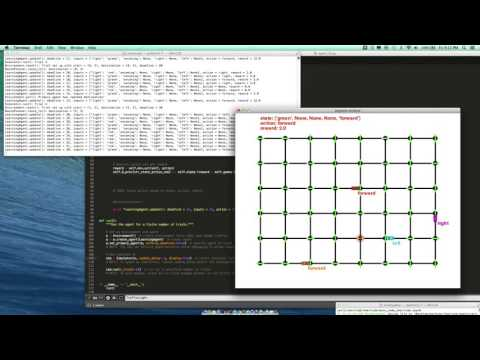

In [10]:
from IPython.display import YouTubeVideo
print 'Smartcab driving with 3 other agents in the environment'
YouTubeVideo('-eYBKD3-NN4') 

Smartcab driving with 20 other agents in the environment


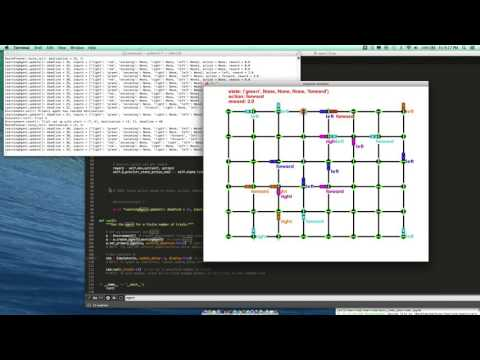

In [11]:
print 'Smartcab driving with 20 other agents in the environment'
YouTubeVideo('a4X9R7v3mrc') 